## TF Binding Prediction Analysis
### Inhyeok Daniel Lee
### April 10 2025

This notebook analyzes the results of my trained CNN model designed to predict Homer TF binding scores from DNA sequences.
This model is mainly inspired by two milestone CNN models:
1) VGGNet (VGG stands for Visual Geometry Group) in 2014
    * Stacking filter of size 3 could incrementally capture larger receptive fields (stack of 2 -> 5, 3 -> 7, ...)
    * Adding more convolutional layers introduce more non-linearity, which aids complex feature representation within the float32 scale.
    * Stacking small filters is incredibly economical compared to using one big filter.
    * Stacking small filters introduce hierarchical feature learning from low-level to high-level.
2) ResNet in 2015
    * Approximating the residual between inputs and feature mapping is more beneficial than approximating the native feature mapping due to better gradient flow (gradient flows better near 0).
    * Learning residuals every 2 convolutional layer is shown to be performing best by empirical studies (every 3 convolutional layer for much deeper architecture).
        Learning residuals every convolutional layer may perform undesirably because they may impede complex feature representation.

References
VGGNet: https://arxiv.org/abs/1409.1556 \
ResNet: https://arxiv.org/abs/1512.03385


## 1. Imports and Setup

In [4]:
import os
import gzip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import random
from IPython.display import Image, display

## 2. Configuration

In [ ]:
# Data Configuration
DATA_DIR = 'data'
SEQ_FILE = os.path.join(DATA_DIR, 'chr22_sequences.txt.gz')
SCORE_FILE = os.path.join(DATA_DIR, 'chr22_scores.txt.gz')
MODEL_WEIGHTS_FILE = 'lee-inhyeok-model.pth'
TRAINING_HISTORY_IMG = 'training_history.png'
EXAMPLE_PREDICTION_IMG = 'example_prediction.png'

# Model Hyperparameters
NUM_CHANNELS = 32
NUM_RES_BLOCKS = 3
DROPOUT_RATE = 0.2
KERNEL_SIZE = 3

# Analysis Parameters
BATCH_SIZE = 64 
VALIDATION_SPLIT = 0.2 # Must match the split used during training
NUM_PLOT_SAMPLES = 5

## 3. Helper Functions

In [ ]:
def one_hot_encode(sequence):
    """Converts a DNA sequence string to a one-hot encoded tensor."""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoded = torch.zeros((4, seq_len), dtype=torch.float32)
    for i, base in enumerate(sequence.upper()):
        idx = mapping.get(base, -1)
        if idx != -1:
            encoded[idx, i] = 1.0
    return encoded

def calculate_pearsonr(preds, targets):
    """Calculates Pearson correlation, handling potential NaNs."""
    # Ensure inputs are tensors on CPU
    if isinstance(preds, np.ndarray):
        preds = torch.from_numpy(preds)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
        
    preds_flat = preds.detach().cpu().numpy().flatten()
    targets_flat = targets.detach().cpu().numpy().flatten()

    valid_indices = np.isfinite(preds_flat) & np.isfinite(targets_flat)
    preds_flat = preds_flat[valid_indices]
    targets_flat = targets_flat[valid_indices]

    if len(preds_flat) < 2:
        return 0.0

    try:
        r, _ = pearsonr(preds_flat, targets_flat)
        return r if np.isfinite(r) else 0.0
    except ValueError:
        return 0.0

def plot_comparison(pred, obs, title="Comparison", save_path=None):
    """Plots predicted vs observed scores for a single sequence."""
    # Ensure inputs are numpy arrays
    if isinstance(pred, torch.Tensor):
         pred = pred.detach().cpu().numpy()
    if isinstance(obs, torch.Tensor):
         obs = obs.detach().cpu().numpy()
         
    r_value = calculate_pearsonr(torch.tensor(pred), torch.tensor(obs))
    x = np.arange(len(pred))
    bar_width = 0.4
    plt.figure(figsize=(12, 5))
    plt.bar(x - bar_width/2, pred, width=bar_width, label="Predicted", alpha=0.7, color='b')
    plt.bar(x + bar_width/2, obs, width=bar_width, label="Observed", alpha=0.7, color='r')
    plt.xlabel("Position in sequence window")
    plt.ylabel("Homer Score")
    plt.title(f"{title}\nPearson R: {r_value:.3f}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show() # Display plot directly in notebook

## 4. Data Loading

In [7]:
class TFBindiingDataset(Dataset):
    def __init__(self, sequences_df, scores_df):
        self.sequences_df = sequences_df
        self.scores_df = scores_df
        # Check if number of sequences matches number of score columns
        if len(self.sequences_df) != len(self.scores_df.columns):
             print(f"Warning: Mismatch sequences ({len(self.sequences_df)}) vs scores ({len(self.scores_df.columns)}). Assuming order matches and truncating scores if necessary.")
             num_seqs = len(self.sequences_df)
             self.score_tensors = [torch.tensor(self.scores_df[col].values, dtype=torch.float32) for col in self.scores_df.columns[:num_seqs]]
        else:
             self.score_tensors = [torch.tensor(self.scores_df[col].values, dtype=torch.float32) for col in self.scores_df.columns]
        
        # Pre-encode sequences 
        self.encoded_sequences = [one_hot_encode(seq) for seq in self.sequences_df['sequence']]
        print(f"Encoded {len(self.encoded_sequences)} sequences.")

    def __len__(self):
        # Length should be consistent with the number of score tensors we decided to keep
        return len(self.score_tensors)

    def __getitem__(self, idx):
        # Return pre-encoded sequence and corresponding score tensor
        if idx < len(self.encoded_sequences) and idx < len(self.score_tensors):
             return self.encoded_sequences[idx], self.score_tensors[idx]
        else:
             raise IndexError(f"Index {idx} out of bounds.")

# Load data from files
print("Loading data...")
try:
    sequences_df = pd.read_csv(SEQ_FILE, sep="\t", compression='gzip')
    scores_df = pd.read_csv(SCORE_FILE, sep="\t", compression='gzip')
    print(f"Loaded {len(sequences_df)} sequences and {len(scores_df.columns)} score vectors.")
except FileNotFoundError:
    print(f"Error: Data files not found. Ensure '{SEQ_FILE}' and '{SCORE_FILE}' exist.")
    # Handle error appropriately, maybe raise it
except Exception as e:
    print(f"Error loading data: {e}")
    # Handle error

# Create the full dataset
full_dataset = TFBindiingDataset(sequences_df, scores_df)

Loading data...
Loaded 23139 sequences and 23139 score vectors.
Encoded 23139 sequences.


## 5. Model Definition

In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block with LayerNorm."""
    def __init__(self, num_channels, kernel_size, dropout_rate):
        super().__init__()
        # For Conv1d output (Batch, Channels, Length), we normalize over Channels and Length
        norm_shape = [num_channels, 300] # LayerNorm needs the shape of the tensor (except for the batch dimension)
        
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               stride=1, padding=kernel_size // 2, bias=False)
        self.norm1 = nn.LayerNorm(norm_shape)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               stride=1, padding=kernel_size // 2, bias=False)
        self.norm2 = nn.LayerNorm(norm_shape)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += identity # Add shortcut
        out = self.relu2(out)
        return out

class BindingPredictorCNN(nn.Module):
    def __init__(self, num_channels, num_blocks, kernel_size, dropout_rate):
        super().__init__()
        initial_norm_shape = [num_channels, 300]
        
        self.initial_conv = nn.Conv1d(4, num_channels, kernel_size,
                                      stride=1, padding=kernel_size // 2, bias=False)
        self.initial_norm = nn.LayerNorm(initial_norm_shape)
        self.initial_relu = nn.ReLU()

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels, kernel_size, dropout_rate) for _ in range(num_blocks)]
        )

        self.final_conv = nn.Conv1d(num_channels, 1, kernel_size=1, stride=1, padding=0, bias=True)
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_norm(x)
        x = self.initial_relu(x)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        x = x.squeeze(1) # Remove channel dimension -> (Batch, 300)
        return x

## 6. Load Pre-trained Model

In [ ]:
# Device Setup (MPS)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device (Apple Silicon GPU).")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# Initialize Model Structure
model = BindingPredictorCNN(
    num_channels=NUM_CHANNELS,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE,
    dropout_rate=DROPOUT_RATE
)

# Load Saved Weights
try:
    # Load weights onto the device directly
    model.load_state_dict(torch.load(MODEL_WEIGHTS_FILE, map_location=device))
    model.to(device)
    model.eval()     # Set model to evaluation mode (disables dropout!!!, etc.)
    print(f"Successfully loaded model weights from {MODEL_WEIGHTS_FILE}")
except FileNotFoundError:
    print(f"Error: Model weights file not found at {MODEL_WEIGHTS_FILE}. Cannot proceed with analysis.")
except Exception as e:
    print(f"Error loading model weights: {e}")

# Print model structure
print("\nModel Architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using MPS device (Apple Silicon GPU).
Successfully loaded model weights from best_tf_binding_model.pth

Model Architecture:
BindingPredictorCNN(
  (initial_conv): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (initial_norm): LayerNorm((32, 300), eps=1e-05, elementwise_affine=True)
  (initial_relu): ReLU()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (norm1): LayerNorm((32, 300), eps=1e-05, elementwise_affine=True)
      (relu1): ReLU()
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (norm2): LayerNorm((32, 300), eps=1e-05, elementwise_affine=True)
      (relu2): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (norm1): LayerNorm((32, 300), eps=1e-05, elementwise_affine=True)
      (relu1): R

## 7. Display Training Results

Displaying saved training history plot:


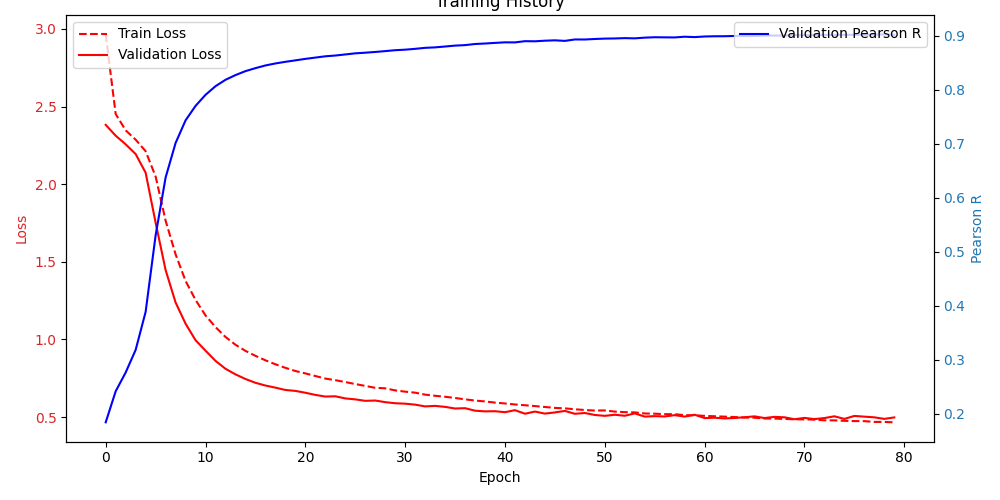

In [12]:
print("Displaying saved training history plot:")
if os.path.exists(TRAINING_HISTORY_IMG):
    display(Image(filename=TRAINING_HISTORY_IMG))
else:
    print(f"Warning: {TRAINING_HISTORY_IMG} not found.")

## 8. Inference on Validation Set Samples

Validation set size: 4627
Loaded first validation batch with size: 64
Performing inference on the batch...
Inference complete.

Plotting 5 random samples from the first validation batch:


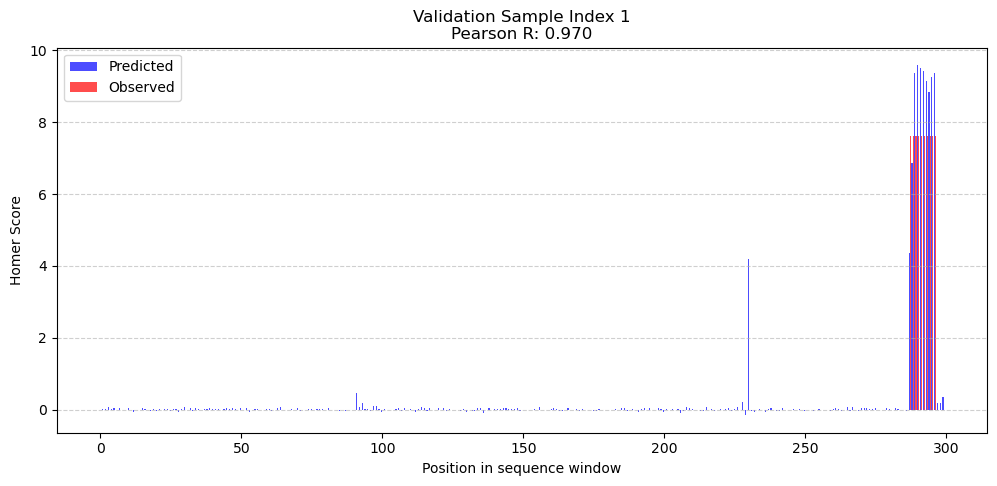

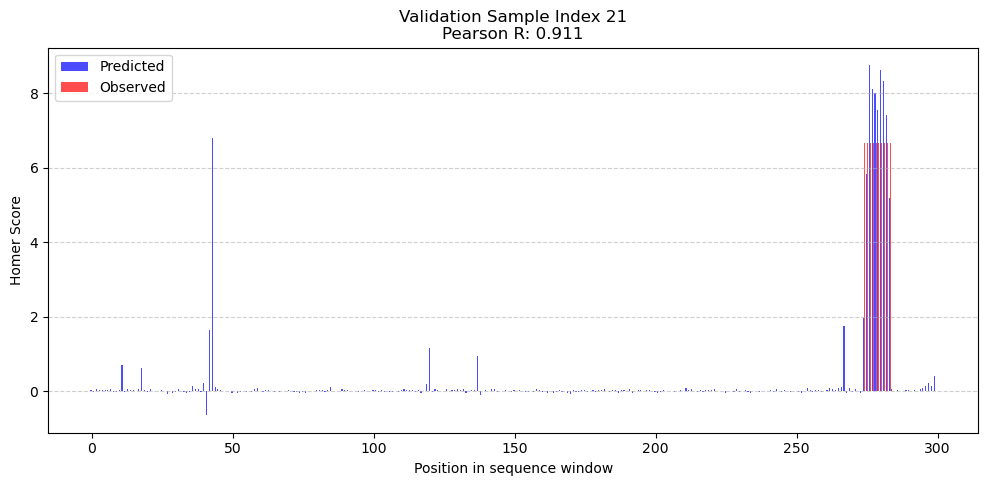

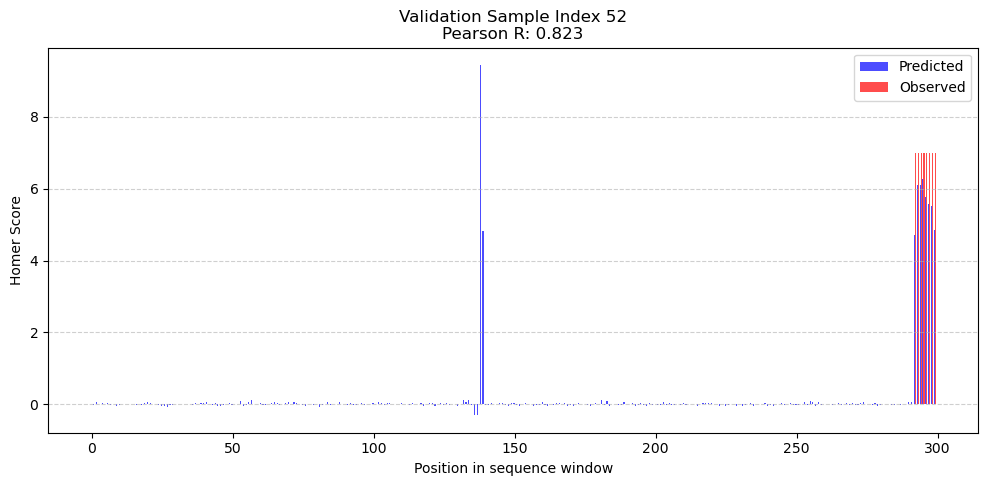

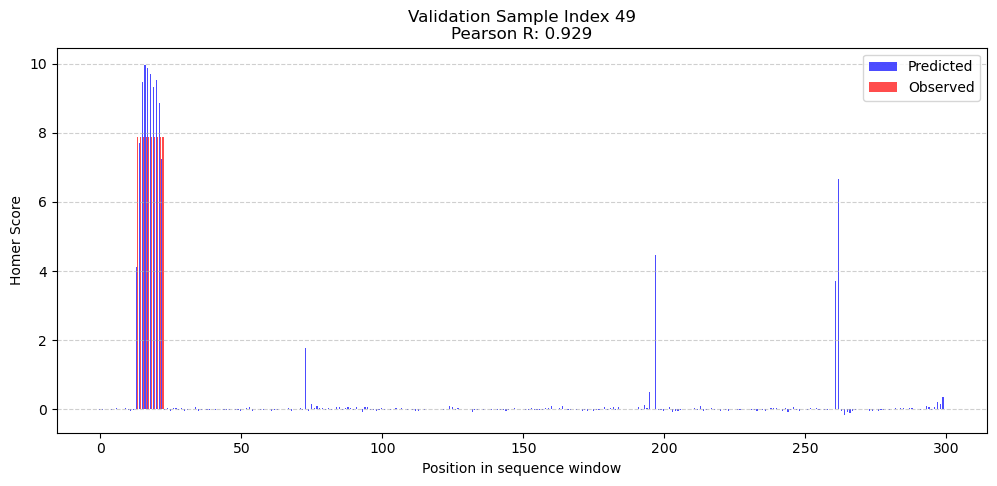

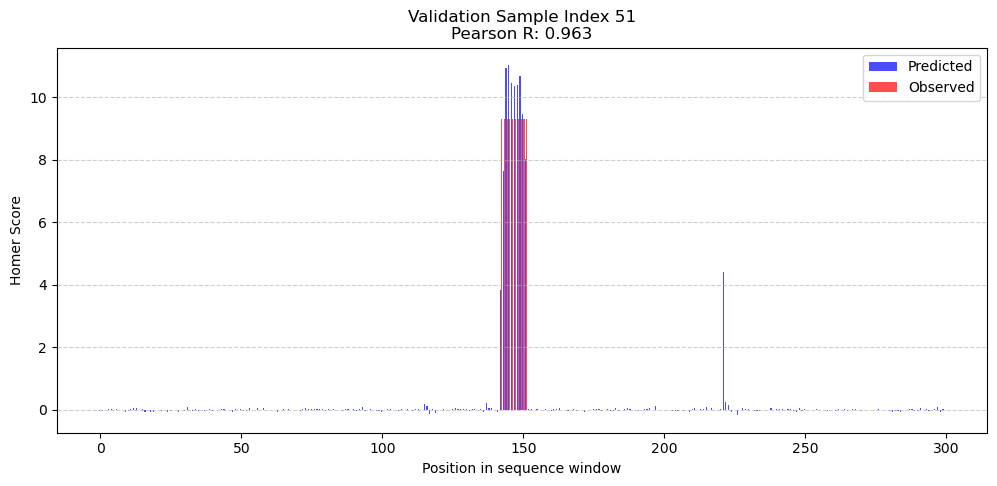

In [ ]:
# Recreate validation split to get the same validation samples
# torch.manual_seed(123)
val_size = int(len(full_dataset) * VALIDATION_SPLIT)
train_size = len(full_dataset) - val_size
_, val_dataset = random_split(full_dataset, [train_size, val_size]) # We only need validation set here

print(f"Validation set size: {len(val_dataset)}")

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle for inference

# Get the first batch
try:
    inputs, targets = next(iter(val_loader))
    inputs = inputs.to(device)
    targets = targets.to(device)
    print(f"Loaded first validation batch with size: {inputs.shape[0]}")
except StopIteration:
    print("Error: Validation loader is empty.")
    # Handle error

# Perform inference
print("Performing inference on the batch...")
with torch.no_grad(): # Ensure gradients are not calculated
    outputs = model(inputs)
print("Inference complete.")

# Plot random samples from the batch
actual_batch_size = inputs.shape[0]
num_to_plot = min(NUM_PLOT_SAMPLES, actual_batch_size)

if num_to_plot > 0:
    print(f"\nPlotting {num_to_plot} random samples from the first validation batch:")
    random_indices = random.sample(range(actual_batch_size), num_to_plot)
    
    for i in random_indices:
        plot_comparison(outputs[i], targets[i], title=f"Validation Sample Index {i}")
else:
    print("Batch was empty, cannot plot samples.")

## 9. Summary

The notebook demonstrates loading the pre-trained model, visualizing its training history, and performing inference on new data, showing its predictive capability on validation samples.